# Counter diffusion and reaction in a slab

Reaction: $A+B\rightarrow *$

$\mathrm{div}(-D \, \mathrm{grad} (c_A) ) = -k \, c_A c_B$, $\mathrm{div}(-D \, \mathrm{grad} (c_B)) = -k \, c_A c_B$, 

with boundary conditions: $c_A(0)=1$, $\frac{\partial c_A(L)}{\partial n} = 0$, $\frac{\partial c_B(0)}{\partial n} = 0$, $c_B(L)=1$

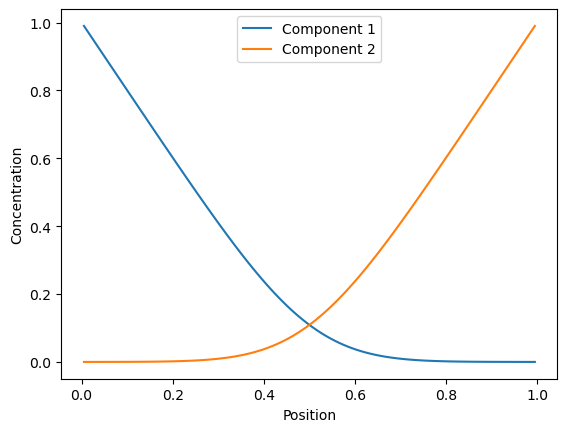

In [1]:
import numpy as np
from scipy.sparse import linalg as sla
import matplotlib.pyplot as plt
from pymrm import construct_grad, construct_div, NumJac

# Physical parameters
num_c = 2
L = 1.0
D = 1
k = 500
bc_L = {'a': 0, 'b': 1, 'd': [[1, 0]]}
bc_R = {'a': 0, 'b': 1, 'd': [[0, 1]]}

# Reaction kinetics
def reaction(c, k):
    f = np.empty_like(c)
    r = k * c[:, 0] * c[:, 1]
    f[:, 0] = -r
    f[:, 1] = -r
    return f

# Numerical parameters
num_x = 100
shape = (num_x, num_c)

# Grid setup
x_f = np.linspace(0, L, num_x+1)
x_c = 0.5*(x_f[:-1] + x_f[1:])

# numerical differentiation object for Jacobian calculation of reaction term
numjac = NumJac(shape)

# Construct gradient and divergence matrices
Grad, grad_bc = construct_grad(shape, x_f, x_c , bc = (bc_L, bc_R), axis=0)
Div = construct_div(shape, x_f, nu=0, axis=0)
Jac_disp = Div @ (D * Grad)
jac_disp_bc = Div @ (D * grad_bc)

# Iteration loop
c = np.zeros(shape)
for i in range(10):
    f_react, Jac_react = numjac(lambda c: reaction(c, k), c)
    g = Jac_disp @ (c.reshape(-1,1)) + jac_disp_bc + f_react.reshape(-1,1)
    lu = sla.splu(Jac_disp + Jac_react)
    c = c - lu.solve(g).reshape(shape)

# Plotting the results
plt.plot(x_c, c[:, 0], label='Component 1')
plt.plot(x_c, c[:, 1], label='Component 2')
plt.xlabel('Position')
plt.ylabel('Concentration')
plt.legend()
plt.show()
